In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.decomposition import PCA
import os
from matplotlib.colors import ListedColormap, Normalize
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import Rbf
from scipy.interpolate import griddata, Rbf, UnivariateSpline
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

from scipy.interpolate import RectBivariateSpline
from matplotlib import colors

#plt.style.use('./stylesheet.mplstyle')

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

2025-05-15 18:55:37.080673: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 18:55:38.875003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# All of this is just getting the data

In [5]:
def read_data(m, U_range,orb):
    i_values = []
    ni_values = []
    
    for U in U_range:
        filename = f"pca_data/ni_vs_i_orb{orb}_U{U}_m{m}_4x4.txt"
        data = np.loadtxt(filename, skiprows=1)
        i = data[:, 0]
        ni = data[:, 1]
        i_values.append(i)
        ni_values.append(ni)
    return i_values, ni_values

In [6]:
filenames=os.listdir('pca_data')

In [7]:

mvals, uvals, orbs = [], [], []

for filename in filenames:
    if 'orb0' in filename:
        orb1_filename = filename.replace('orb0', 'orb1')

        m, u = map(float, (filename.split('_m')[1].split('_')[0], [segment[1:] for segment in filename.split('_') if segment.startswith('U')][0]))

        mvals.append(m)
        uvals.append(u)

        orb0_data = np.loadtxt(f'pca_data/{filename}')
        orb1_data = np.loadtxt(f'pca_data/{orb1_filename}')

        orbitals = np.concatenate((orb1_data[:, 1], orb0_data[:, 1]))
        #orbitals = orb1_data[:,1]-orb0_data[:,1]
        orbs.append(orbitals)

uvals=np.array(uvals)
mvals=np.array(mvals)


In [8]:
len(orbs)

308

In [9]:
orbs[60]

array([ 0.051316,  0.051283,  0.051524,  0.051814, -0.000682, -0.000438,
        0.000315,  0.000902,  0.000532,  0.000268, -0.00039 , -0.000507,
        0.051783,  0.05148 ,  0.051255,  0.05129 , -0.051316, -0.051283,
       -0.051524, -0.051814,  0.000682,  0.000438, -0.000316, -0.000902,
       -0.000531, -0.000268,  0.00039 ,  0.000507, -0.051783, -0.051479,
       -0.051255, -0.05129 ])

m = 2.75 
U = 7.5


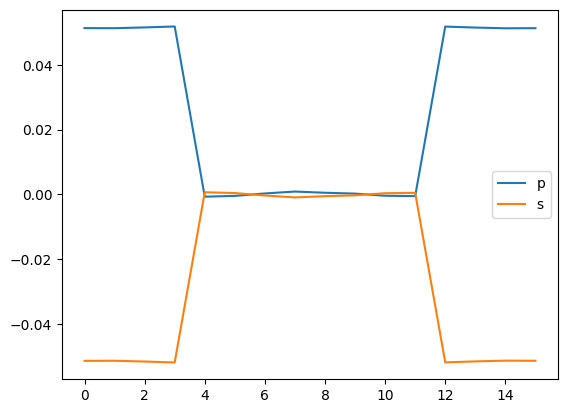

In [10]:
index = 60
print("m =", mvals[index], "\nU =", uvals[207])
plt.plot(orbs[index][:16], label = "p")
plt.plot(orbs[index][16:], label = "s")
plt.legend()

In [11]:
orbs = np.array(orbs)


# Here we generate new_orbs, which are the old orbs averaged every 4 points (aka up the ladder)
averages = []
for i in range(0,32,4):
    averages.append(np.average(orbs[:,i:i+4], axis = 1))

new_orbs = np.stack(averages, axis = 1)


m = 1.0 
U = 7.5


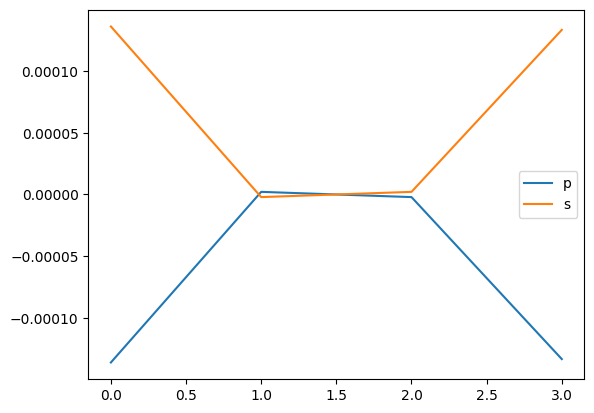

In [12]:
print("m =", mvals[207], "\nU =", uvals[207])
plt.plot(new_orbs[207][:4], label = "p")
plt.plot(new_orbs[207][4:], label = "s")
plt.legend()

In [13]:
# Here we perform PCA

In [14]:
orbs_shape = 8

In [15]:
new_orbs = np.array(new_orbs)
pca = PCA(n_components=1)
principal_components = pca.fit_transform(new_orbs)
eigenvalues = pca.explained_variance_

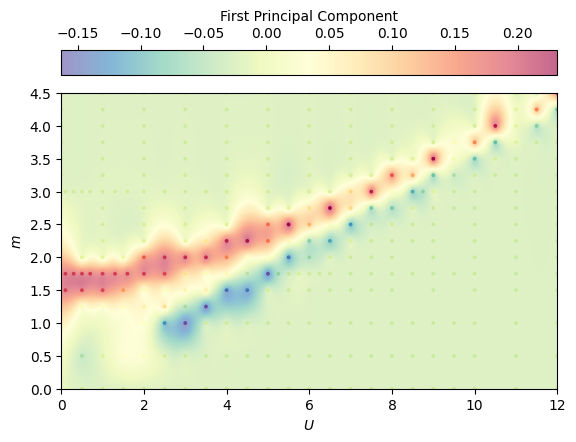

In [16]:
uvals = np.array(uvals)
mvals = np.array(mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

rbf = Rbf(uvals, mvals, principal_components[:, 0], function='linear')
interp_vals = rbf(u_grid, m_grid)


normalized_values = (principal_components[:, 0] - (-0.2)) / (0.4 - (-0.2))

plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(label="First Principal Component",location='top')
plt.xlabel(r'$U$')
plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')

#plt.savefig('PCAphasediagramBHZ.svg')
#plt.savefig('PCAphasediagramBHZ.pdf')

#plt.scatter(uvals, mvals, c = principal_components[:, 0] > -.024)

plt.show()


In [17]:
# Here we make a normal autoencoder (not a VAE)

In [18]:
# First we train on all 32 orbitals

In [19]:
orbs = np.array(orbs)

In [20]:
#orbs_zeroed = orbs - np.min(orbs)
#orbs_normalized = orbs_zeroed/np.max(orbs_zeroed)
orbs_normalized = orbs/np.max(orbs)


x_train, x_test, y_train, y_test = train_test_split(orbs_normalized, orbs_normalized, test_size=0.2)

In [21]:
orbs_shape = 32

In [22]:
autoencoder = keras.Sequential(
[
    keras.layers.Dense(30, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(1, activation='tanh', name="middle"),
    keras.layers.Dense(30, activation='tanh'),
    keras.layers.Dense(orbs_shape, activation='tanh')
])
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                990       
                                                                 
 middle (Dense)              (None, 1)                 31        
                                                                 
 dense_1 (Dense)             (None, 30)                60        
                                                                 
 dense_2 (Dense)             (None, 32)                992       
                                                                 
Total params: 2073 (8.10 KB)
Trainable params: 2073 (8.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
batch_size = 20
epochs = 300
training_history = autoencoder.fit(x_train,x_train, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,x_test))

Epoch 1/300
13/13 [==============================] - 1s 10ms/step - loss: 0.0459 - accuracy: 0.0407 - val_loss: 0.0253 - val_accuracy: 0.0000e+00
Epoch 2/300
13/13 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.0122 - val_loss: 0.0197 - val_accuracy: 0.0484
Epoch 3/300
13/13 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.1220 - val_loss: 0.0140 - val_accuracy: 0.2097
Epoch 4/300
13/13 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.4146 - val_loss: 0.0102 - val_accuracy: 0.3065
Epoch 5/300
13/13 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.4309 - val_loss: 0.0075 - val_accuracy: 0.3065
Epoch 6/300
13/13 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.4268 - val_loss: 0.0055 - val_accuracy: 0.3226
Epoch 7/300
13/13 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.4228 - val_loss: 0.0041 - val_accuracy: 0.3065
Epoch 8/

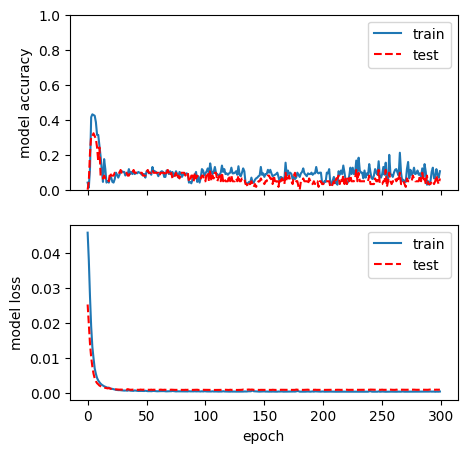

In [24]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

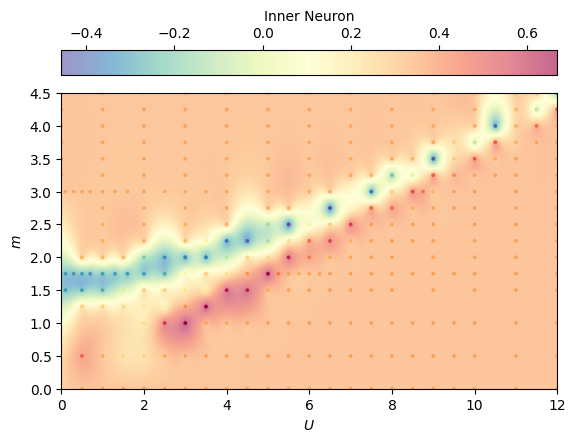

In [25]:
inner_neuron = keras.Model(
  inputs=autoencoder.input,
  outputs=autoencoder.get_layer("middle").output)

inner_output = np.array(inner_neuron(orbs_normalized))

uvals = np.array(uvals)
mvals = np.array(mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

rbf = Rbf(uvals, mvals, inner_output, function='linear')
interp_vals = rbf(u_grid, m_grid)

normalized_values = inner_output

plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(label="Inner Neuron",location='top')
plt.xlabel(r'$U$')
plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')
plt.show()

In [26]:
# Next we train on the averaged 8 orbitals

In [27]:
#new_orbs_zeroed = new_orbs - np.min(new_orbs)
#new_orbs_normalized = new_orbs_zeroed / np.max(new_orbs_zeroed)

new_orbs_normalized = new_orbs / np.max(new_orbs)

In [28]:
def undo_orb_norm(inputs):
    
    n_orbs = int(len(inputs[0]))
                 
    if n_orbs == 32:
                 
        #fixed_orbs = inputs*np.max(orbs_zeroed)+np.min(orbs)
        fixed_orbs = inputs*np.max(new_orbs)

    elif n_orbs == 8:
        
        #fixed_orbs = inputs*np.max(new_orbs_zeroed)+np.min(new_orbs)
        fixed_orbs = inputs*np.max(orbs)
                     
    return fixed_orbs

In [29]:
x_train, x_test, y_train, y_test = train_test_split(new_orbs_normalized, new_orbs_normalized, test_size=0.2)

In [30]:
orbs_shape = 8

In [31]:
autoencoder = keras.Sequential(
[
    keras.layers.Dense(30, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(1, activation='tanh', name="middle"),
    keras.layers.Dense(30, activation='tanh'),
    keras.layers.Dense(orbs_shape, activation='tanh')
])
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                270       
                                                                 
 middle (Dense)              (None, 1)                 31        
                                                                 
 dense_4 (Dense)             (None, 30)                60        
                                                                 
 dense_5 (Dense)             (None, 8)                 248       
                                                                 
Total params: 609 (2.38 KB)
Trainable params: 609 (2.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
batch_size = 20
epochs = 100
training_history = autoencoder.fit(x_train,x_train, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,x_test))

Epoch 1/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0463 - accuracy: 0.0813 - val_loss: 0.0330 - val_accuracy: 0.1290
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.1341 - val_loss: 0.0319 - val_accuracy: 0.1613
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.1748 - val_loss: 0.0290 - val_accuracy: 0.2581
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.2439 - val_loss: 0.0218 - val_accuracy: 0.3226
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.2927 - val_loss: 0.0127 - val_accuracy: 0.3387
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.2886 - val_loss: 0.0060 - val_accuracy: 0.3387
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.4593 - val_loss: 0.0032 - val_accuracy: 0.5645
Epoch 8/100
1

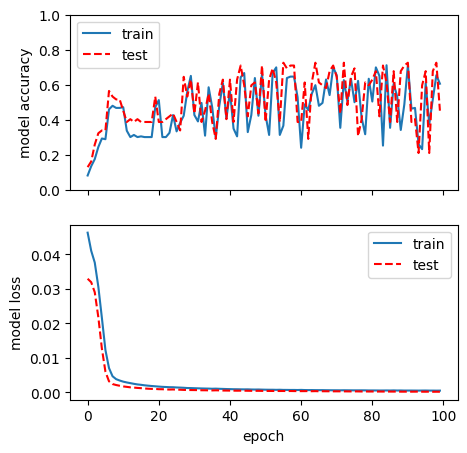

In [33]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

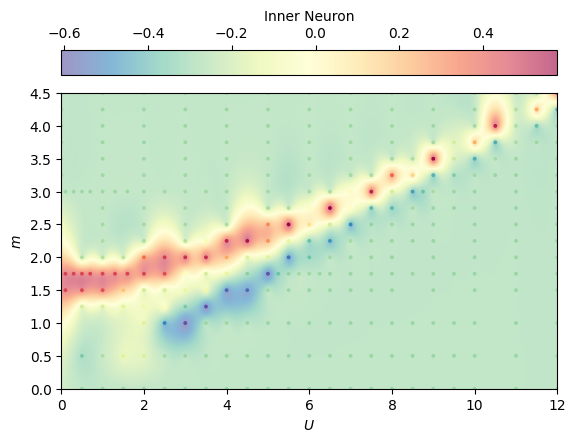

In [34]:
inner_neuron = keras.Model(
  inputs=autoencoder.input,
  outputs=autoencoder.get_layer("middle").output)

inner_output = np.array(inner_neuron(new_orbs_normalized))

uvals = np.array(uvals)
mvals = np.array(mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

rbf = Rbf(uvals, mvals, inner_output, function='linear')
interp_vals = rbf(u_grid, m_grid)

normalized_values = inner_output

plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(label="Inner Neuron",location='top')
plt.xlabel(r'$U$')
plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')
plt.show()

In [35]:
# Ultimately both networks perform relatively the same, however the accuracy for the averaged orbitals was slightly better (it trained slightly faster).
# This makes since since it would be easier for the network to overfit to the tiny fluctuations that the averaging removes

In [36]:
muvals = np.concatenate(np.expand_dims([mvals, uvals], axis = 2), axis = 1)

In [37]:
# This is just a function to plot multiple orbs
def multidisplay_orbs(inputs, inputs_2 = np.array([]), mu = muvals, num_cols = 4):
    n = len(inputs)
    num_rows = int(np.ceil(n/num_cols))
    
    if len(inputs_2) == 0:
        second_input = False
    else:
        second_input = True

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols,4*num_rows))
    fig.tight_layout(h_pad = 3)

    n_s = int(len(inputs[0])/2) # this is just the number of s orbitals (and number of p orbitals), to plot them seperately
    
    for i in range(0, num_rows):
        for j in range (0,num_cols):
            index = int(j+i*num_cols)
            ax[i,j].plot(inputs[index][:n_s], label = "s")
            ax[i,j].plot(inputs[index][n_s:2*n_s], label = "p")
            try:
                if len(mu[0]) == 2:
                    ax[i,j].set_title(f"m = {mu[index][0]}, U = {mu[index][1]}")
            except:
                ax[i,j].set_title(f" sample point = {mu[index]}")

            if second_input:
                
                ax[i,j].plot(inputs_2[index][:n_s], label = "s (2)")
                ax[i,j].plot(inputs_2[index][n_s:2*n_s], label = "p (2)")

            ax[i,j].legend()

In [38]:
def random_indices(max, count):
    return np.random.choice(range(0,max), size=count, replace=False)

In [39]:
random_i = random_indices(max = len(new_orbs_normalized), count = 12)

In [40]:
random_actual = new_orbs_normalized[random_i]
random_predicted = np.array(autoencoder(random_actual))

random_actual = undo_orb_norm(random_actual)
random_predicted = undo_orb_norm(random_predicted)

In [41]:
np.shape(new_orbs_normalized)

(308, 8)

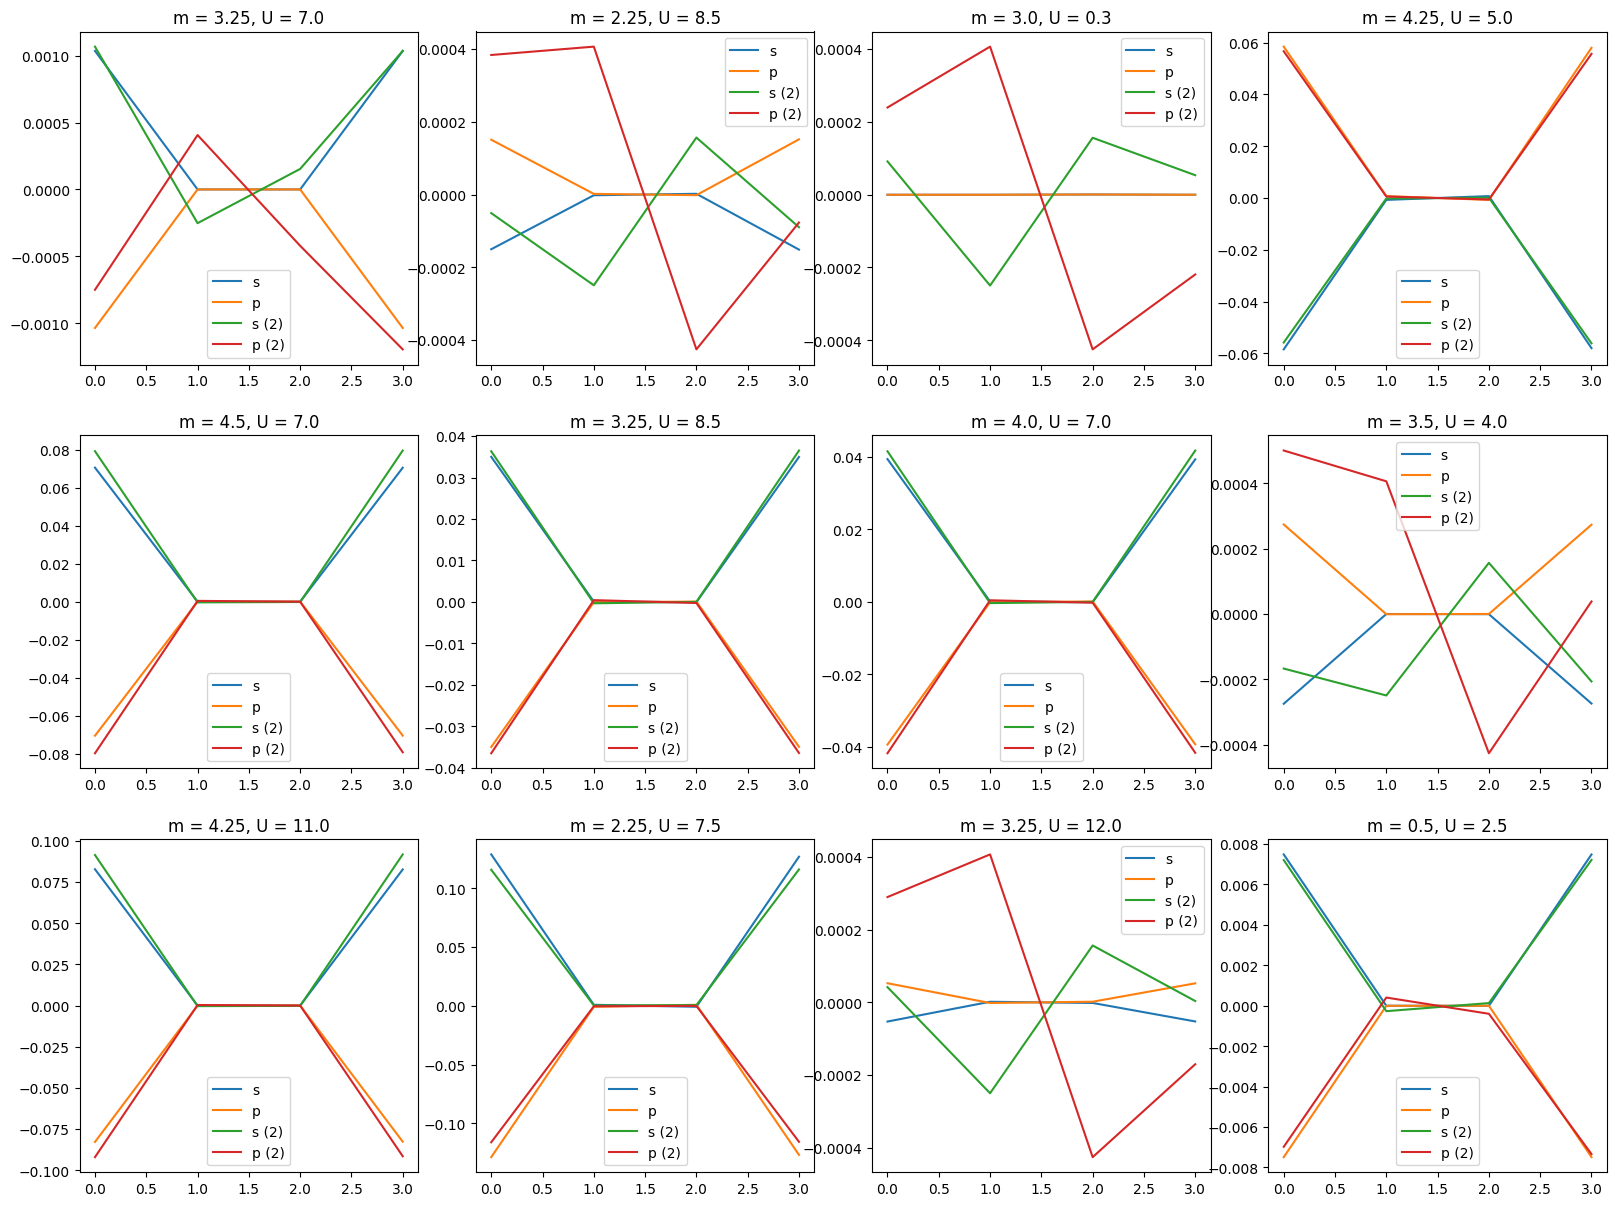

In [42]:
multidisplay_orbs(random_actual, random_predicted)

In [43]:
# Trying a different loss function, cosine similarity

In [44]:
orbs_shape = 8

In [45]:
autoencoder = keras.Sequential(
[
    keras.layers.Dense(200, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(10, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(1, activation='linear', name="middle"),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(200, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(orbs_shape, activation='linear')
])
autoencoder.compile(loss='cosine_similarity', optimizer='Adam', metrics=['accuracy'])
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               1800      
                                                                 
 dense_7 (Dense)             (None, 10)                2010      
                                                                 
 middle (Dense)              (None, 1)                 11        
                                                                 
 dense_8 (Dense)             (None, 10)                20        
                                                                 
 dense_9 (Dense)             (None, 200)               2200      
                                                                 
 dense_10 (Dense)            (None, 8)                 1608      
                                                                 
Total params: 7649 (29.88 KB)
Trainable params: 7649 (

In [46]:
batch_size = 20
epochs = 100
training_history = autoencoder.fit(x_train,x_train, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,x_test))

Epoch 1/100
13/13 [==============================] - 1s 10ms/step - loss: -0.1650 - accuracy: 0.2073 - val_loss: -0.3406 - val_accuracy: 0.4839
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: -0.4321 - accuracy: 0.5000 - val_loss: -0.3637 - val_accuracy: 0.4032
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: -0.4404 - accuracy: 0.3293 - val_loss: -0.3695 - val_accuracy: 0.3548
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: -0.4556 - accuracy: 0.3374 - val_loss: -0.3864 - val_accuracy: 0.4032
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: -0.4933 - accuracy: 0.4350 - val_loss: -0.4949 - val_accuracy: 0.2903
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: -0.6541 - accuracy: 0.2358 - val_loss: -0.7142 - val_accuracy: 0.1935
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: -0.7645 - accuracy: 0.1870 - val_loss: -0.8184 - val_accuracy: 0.387

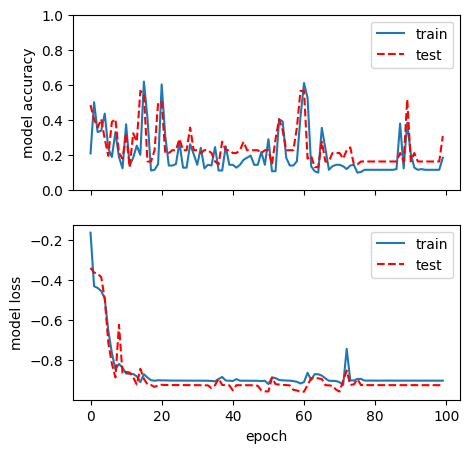

In [47]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

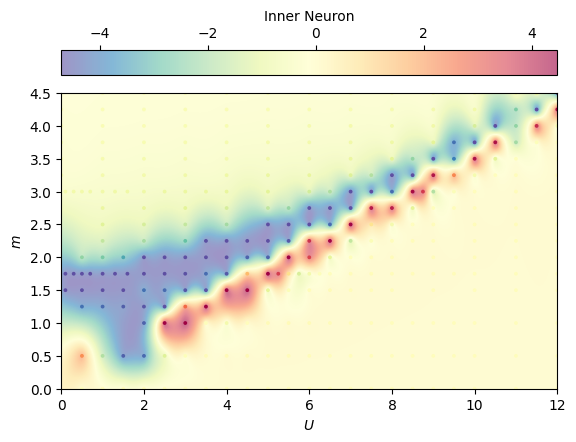

In [48]:
inner_neuron = keras.Model(
  inputs=autoencoder.input,
  outputs=autoencoder.get_layer("middle").output)

inner_output = np.array(inner_neuron(new_orbs_normalized))

uvals = np.array(uvals)
mvals = np.array(mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

rbf = Rbf(uvals, mvals, inner_output, function='linear')
interp_vals = rbf(u_grid, m_grid)

normalized_values = inner_output
#normalized_values = (inner_output - (-0.2)) / (0.4 - (-0.2))

plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(label="Inner Neuron",location='top')
plt.xlabel(r'$U$')
plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')
plt.show()

In [ ]:
# When the cosine similarity is used, better separation is acheived between the phases.

In [49]:
random_i = random_indices(max = len(new_orbs_normalized), count = 8)

In [50]:
random_actual = new_orbs_normalized[random_i]
random_predicted = np.array(autoencoder(random_actual))

random_actual = undo_orb_norm(random_actual)
random_predicted = undo_orb_norm(random_predicted)

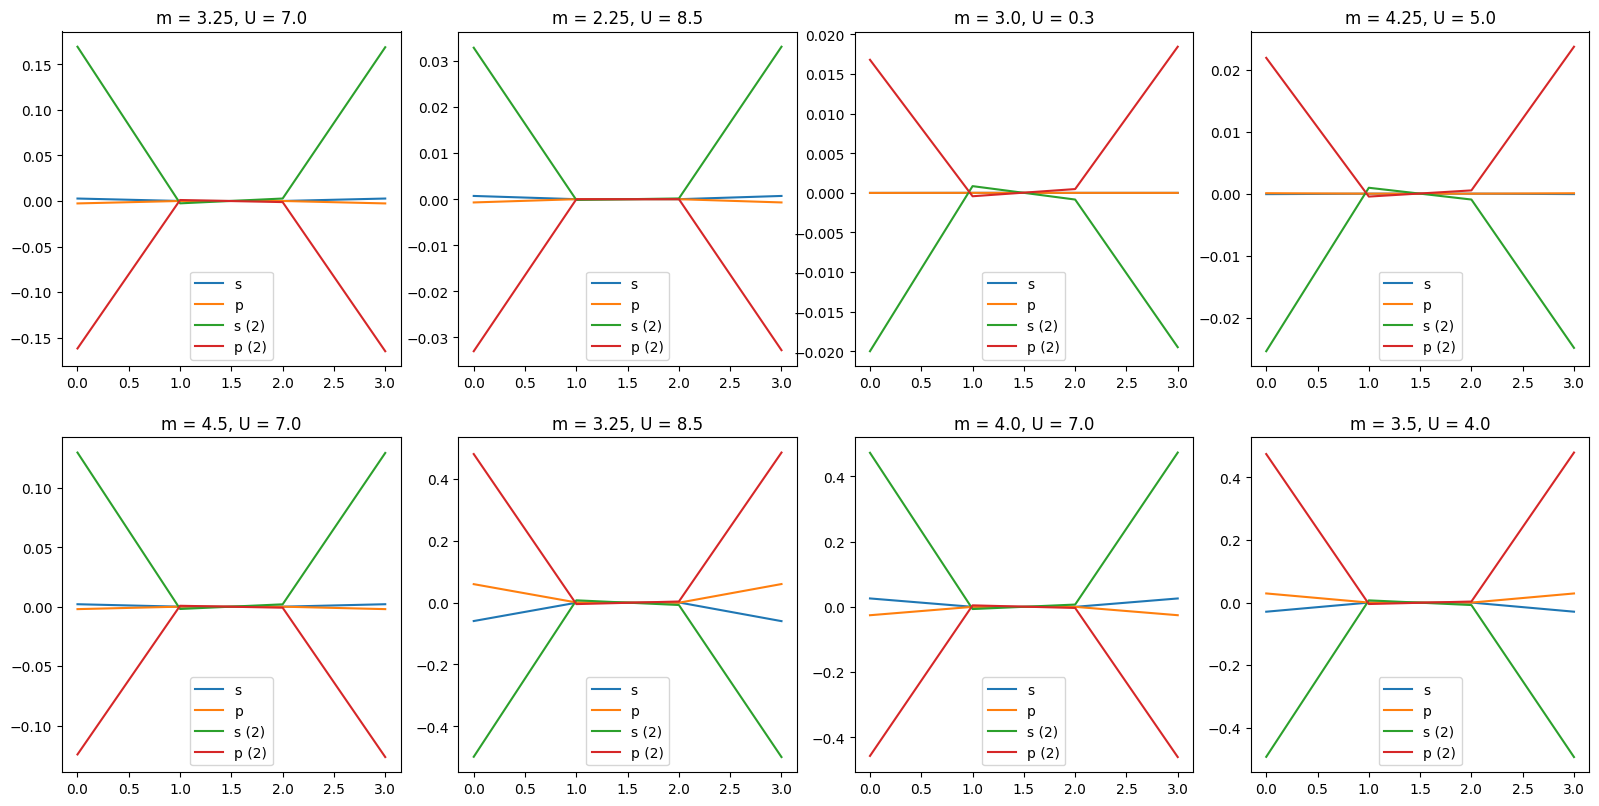

In [51]:
multidisplay_orbs(random_actual, random_predicted)

In [154]:
# Autoencoder trained with cosine predicts poorly. Perhaps because the error does not depend on the magnitude of the "vectors"

In [53]:
# Here we make the VAE

In [54]:
#new_orbs_zeroed = new_orbs - np.min(new_orbs)
#new_orbs_normalized = new_orbs_zeroed / np.max(new_orbs_zeroed)

x_train, x_test, y_train, y_test = train_test_split(new_orbs_normalized, new_orbs_normalized, test_size=0.2)

In [55]:
orbs_shape

8

In [56]:
# Input dimensions
input_dim = orbs_shape

# Latent space dimension
latent_dim = 1

# List of layers 
layer_list = [(200,'tanh'), (10,'tanh')]

output_activation = "linear"

inputs = keras.Input(shape=(input_dim,))
layer = []
previous_layer = inputs
for i, (dim, activ) in enumerate(layer_list):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1}')(previous_layer)
    previous_layer = layer
z_mean = layers.Dense(latent_dim, name = 'z_mean')(layer)
z_log_sigma = layers.Dense(latent_dim, name = 'z_log_sigma')(layer)

In [57]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [58]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [59]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 Dense_1 (Dense)             (None, 200)                  1800      ['input_1[0][0]']             
                                                                                                  
 Dense_2 (Dense)             (None, 10)                   2010      ['Dense_1[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 1)                    11        ['Dense_2[0][0]']             
                                                                                            

In [60]:
# Making decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
previous_layer = latent_inputs

for i, (dim, activ) in enumerate(layer_list[::-1]):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1+len(layer_list)}')(previous_layer)
    previous_layer = layer

outputs = layers.Dense(input_dim, activation=output_activation)(layer)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [61]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1)]               0         
                                                                 
 Dense_3 (Dense)             (None, 10)                20        
                                                                 
 Dense_4 (Dense)             (None, 200)               2200      
                                                                 
 dense_11 (Dense)            (None, 8)                 1608      
                                                                 
Total params: 3828 (14.95 KB)
Trainable params: 3828 (14.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# Make VAE
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='VAE')

In [63]:
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 encoder (Functional)        [(None, 1),               3832      
                              (None, 1),                         
                              (None, 1)]                         
                                                                 
 decoder (Functional)        (None, 8)                 3828      
                                                                 
Total params: 7660 (29.92 KB)
Trainable params: 7660 (29.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# making loss function
reconstruction_loss = keras.losses.cosine_similarity(inputs,outputs)

reconstruction_loss *= input_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])

In [65]:
epochs = 100

training_history = vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=50,
        validation_data=(x_test, x_test), verbose = 1)

Epoch 1/100
5/5 [==============================] - 1s 32ms/step - loss: 1.0692 - accuracy: 0.0732 - val_loss: 1.2406 - val_accuracy: 0.0968
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: -0.0351 - accuracy: 0.2033 - val_loss: 1.0516 - val_accuracy: 0.3226
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: -1.3228 - accuracy: 0.4390 - val_loss: -0.7399 - val_accuracy: 0.5323
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: -1.5960 - accuracy: 0.4675 - val_loss: -1.7953 - val_accuracy: 0.5968
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: -3.2383 - accuracy: 0.5732 - val_loss: -4.1864 - val_accuracy: 0.6613
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: -3.3499 - accuracy: 0.4919 - val_loss: -3.9400 - val_accuracy: 0.1129
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: -3.3466 - accuracy: 0.1463 - val_loss: -3.8497 - val_accuracy: 0.1452
Epoch 8/100
5/5

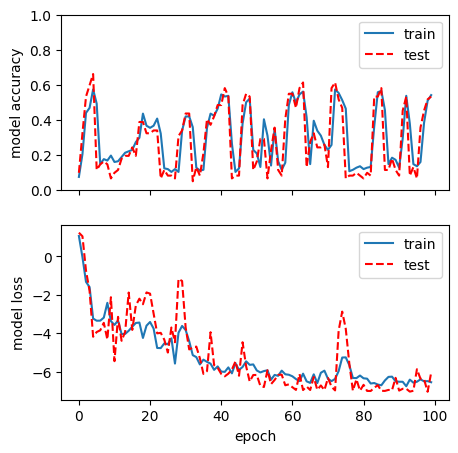

In [66]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

16/16 [==============================] - 0s 754us/step


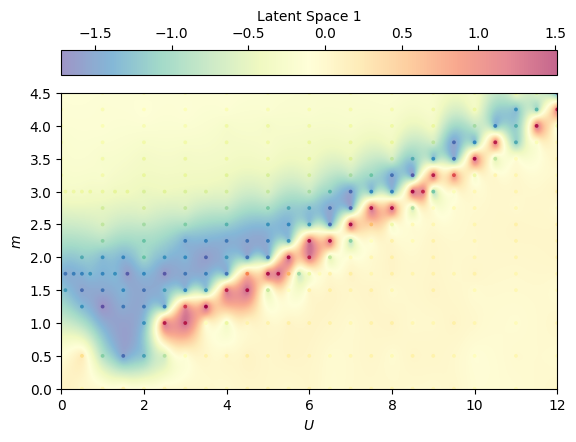

In [67]:
encoded = encoder.predict(new_orbs_normalized, batch_size=batch_size)[2]

for i in range (0, np.shape(encoded)[1]):



    which_latent = i

    latent_value = encoded[:,which_latent]
    uvals = np.array(uvals)
    mvals = np.array(mvals)


    # Set the number of points for interpolation
    num_points = 1000  

    # Create a grid for interpolation 
    u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

    rbf = Rbf(uvals, mvals, latent_value, function='linear')
    interp_vals = rbf(u_grid, m_grid)

    normalized_values = latent_value
    #normalized_values = (latent_value - (-0.2)) / (0.4 - (-0.2))

    plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
    plt.colorbar(label=f"Latent Space {which_latent+1}",location='top')
    plt.xlabel(r'$U$')
    plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
    plt.ylabel(r'$m$')
    


    #plt.scatter(uvals, mvals, c = (encoded > 0))

    plt.show()

In [68]:
random_i = random_indices(max = len(new_orbs_normalized), count = 8)

In [69]:
random_actual = new_orbs_normalized[random_i]
random_predicted = np.array(decoder(encoded))[random_i]

random_actual = undo_orb_norm(random_actual)
random_predicted = undo_orb_norm(random_predicted)

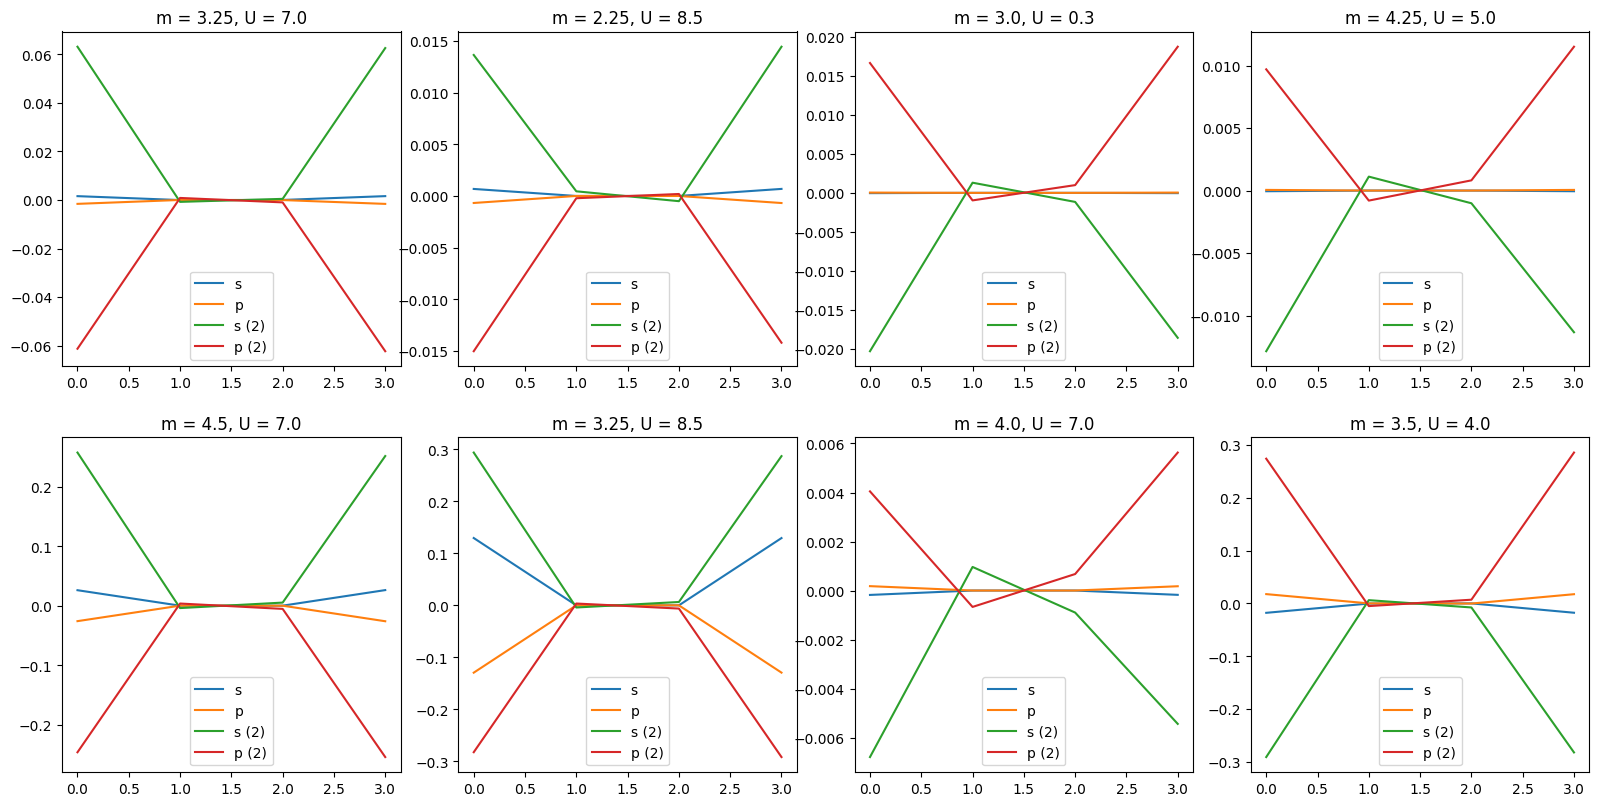

In [70]:
multidisplay_orbs(random_actual, random_predicted)

In [155]:
# The network trained with cosine similarity isn't that good at reconstructing the orbitals, so I'll train another with MSE for new orb generation

In [72]:
#new_orbs_zeroed = new_orbs - np.min(new_orbs)
#new_orbs_normalized = new_orbs_zeroed / np.max(new_orbs_zeroed)

#x_train, x_test, y_train, y_test = train_test_split(new_orbs_normalized, new_orbs_normalized, test_size=0.2)

In [156]:
# MSE VAE

In [73]:
# Input dimensions
input_dim = orbs_shape

# Latent space dimension
latent_dim = 1

# List of layers 
layer_list = [(200,'tanh'), (10,'tanh')]

output_activation = "tanh"

inputs = keras.Input(shape=(input_dim,))
layer = []
previous_layer = inputs
for i, (dim, activ) in enumerate(layer_list):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1}')(previous_layer)
    previous_layer = layer
z_mean = layers.Dense(latent_dim, name = 'z_mean')(layer)
z_log_sigma = layers.Dense(latent_dim, name = 'z_log_sigma')(layer)

In [74]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [75]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [76]:
# Making decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
previous_layer = latent_inputs

for i, (dim, activ) in enumerate(layer_list[::-1]):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1+len(layer_list)}')(previous_layer)
    previous_layer = layer

outputs = layers.Dense(input_dim, activation=output_activation)(layer)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [77]:
# Make VAE
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='VAE')

In [78]:
# making loss function
reconstruction_loss = keras.losses.mean_absolute_error(inputs,outputs)

reconstruction_loss *= input_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])

In [79]:
epochs = 100

training_history = vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=10,
        validation_data=(x_test, x_test), verbose = 1)

Epoch 1/100
25/25 [==============================] - 1s 6ms/step - loss: 0.5990 - accuracy: 0.1748 - val_loss: 0.4780 - val_accuracy: 0.0645
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4148 - accuracy: 0.1626 - val_loss: 0.3487 - val_accuracy: 0.3710
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.4431 - val_loss: 0.3479 - val_accuracy: 0.5484
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3656 - accuracy: 0.3374 - val_loss: 0.4599 - val_accuracy: 0.5968
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.5407 - val_loss: 0.3393 - val_accuracy: 0.3871
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3455 - accuracy: 0.3537 - val_loss: 0.3597 - val_accuracy: 0.5161
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3501 - accuracy: 0.4512 - val_loss: 0.3196 - val_accuracy: 0.2419
Epoch 8/100
2

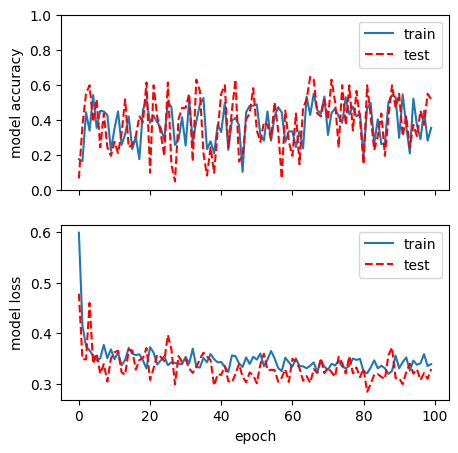

In [80]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

16/16 [==============================] - 0s 785us/step


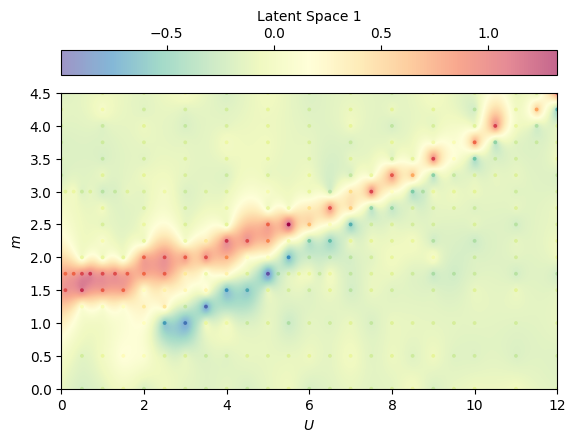

In [81]:
encoded = encoder.predict(new_orbs_normalized, batch_size=batch_size)[2]

for i in range (0, np.shape(encoded)[1]):



    which_latent = i

    latent_value = encoded[:,which_latent]
    uvals = np.array(uvals)
    mvals = np.array(mvals)


    # Set the number of points for interpolation
    num_points = 1000  

    # Create a grid for interpolation 
    u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

    rbf = Rbf(uvals, mvals, latent_value, function='linear')
    interp_vals = rbf(u_grid, m_grid)

    normalized_values = latent_value
    #normalized_values = (latent_value - (-0.2)) / (0.4 - (-0.2))

    plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
    plt.colorbar(label=f"Latent Space {which_latent+1}",location='top')
    plt.xlabel(r'$U$')
    plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
    plt.ylabel(r'$m$')
    


    #plt.scatter(uvals, mvals, c = (encoded > 0))

    plt.show()

In [82]:
# Ive noticed that the VAE is always slightly more "patchy" compared to the normal AE, which I'll attribute to the fact that I'm sampling 
# from the probablity distribution to get the latent space value. Re-executing the above cell will change the patchiness.

In [83]:
random_i = random_indices(max = len(new_orbs_normalized), count = 8)

In [84]:
random_actual = new_orbs_normalized[random_i]
random_predicted = np.array(decoder(encoded))[random_i]

random_actual = undo_orb_norm(random_actual)
random_predicted = undo_orb_norm(random_predicted)

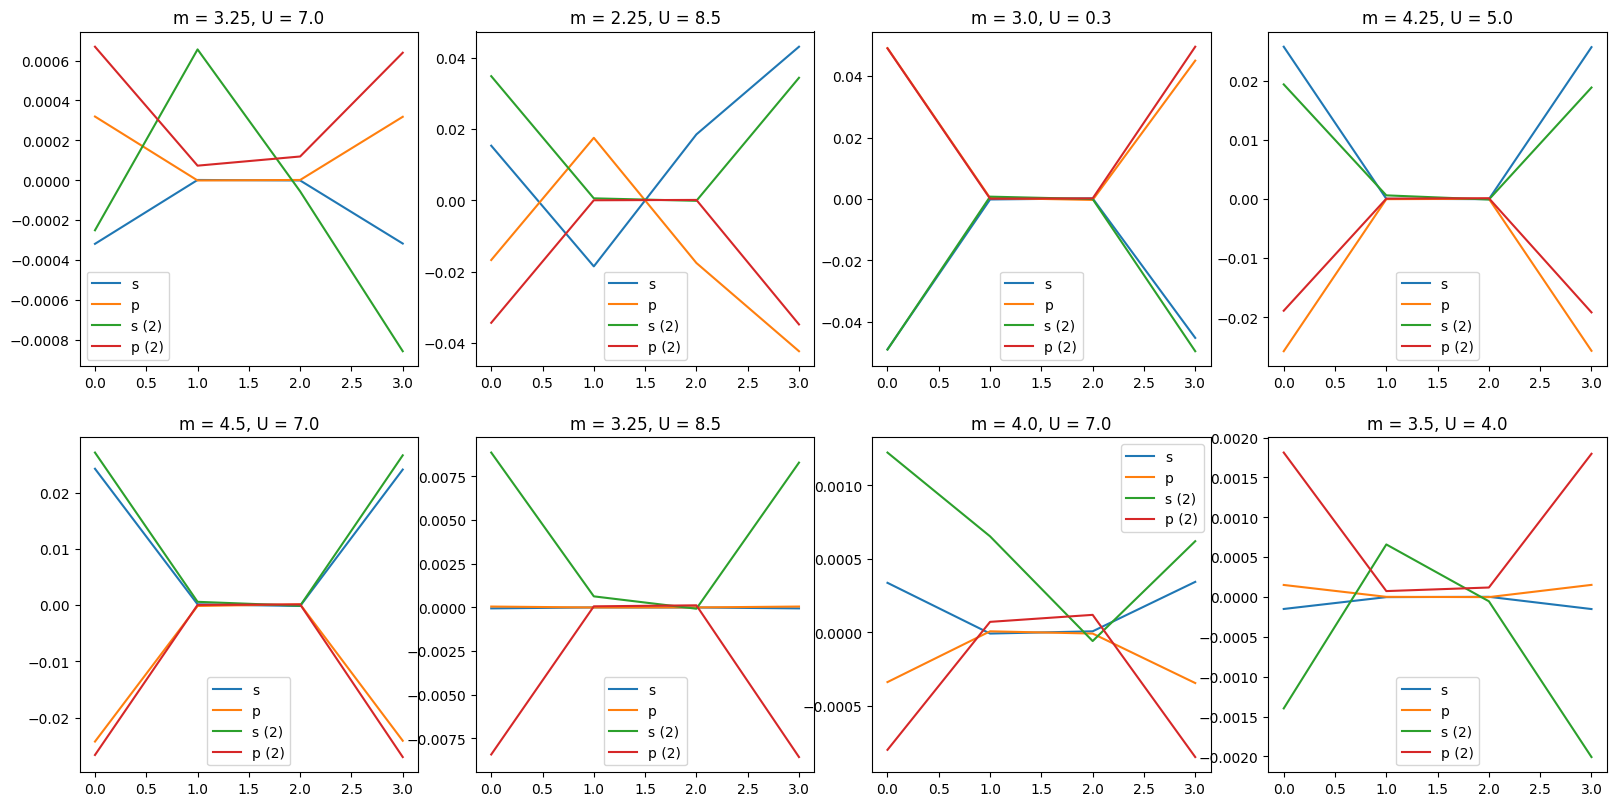

In [85]:
multidisplay_orbs(random_actual, random_predicted)

In [86]:
# Here we will generate never before seen orbitals!

In [87]:
sample_points = np.linspace(-1,1,8) # sampling between -1 and 1 stdev
generated_orbs = decoder(sample_points)

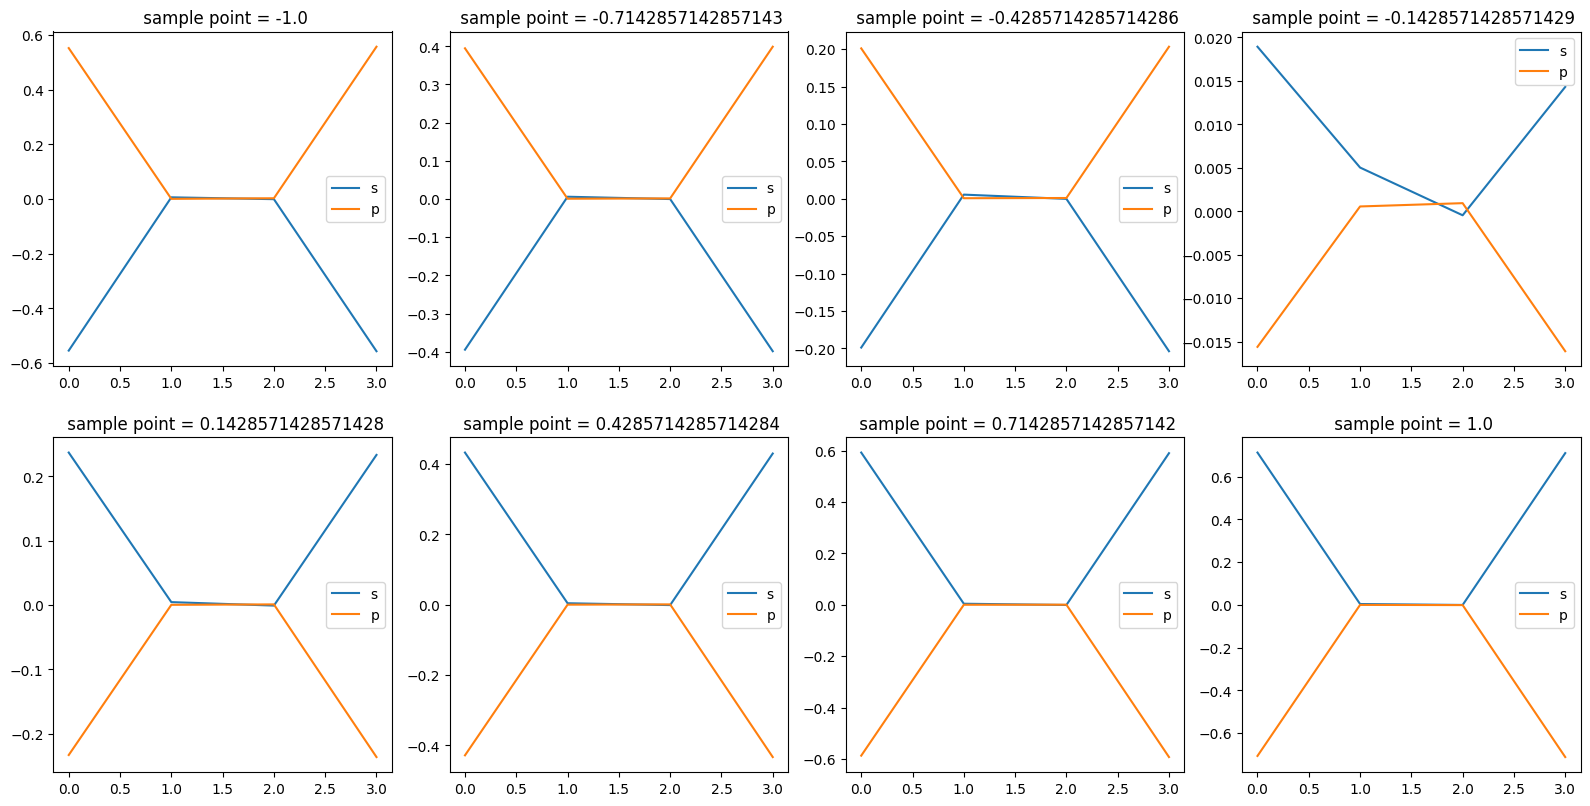

In [88]:
multidisplay_orbs(generated_orbs, mu = sample_points, num_cols = 4)

In [89]:
# Next, we will add spin correlation data to see if we can get better resolution between the NM BI and AFM MI states
# ( I started working on part this before realizing that using cosine similarity would actually let the autoencoder tell them apart )

In [90]:
# Here we download the spin spin correlation data

In [91]:
filenames_2=os.listdir('SScor_data')

In [92]:

mvals_2, uvals_2, ss_cors = [], [], []

for filename in filenames_2:
    m, u = map(float, (filename.split('_m')[1].split('_')[0], [segment[1:] for segment in filename.split('_') if segment.startswith('U')][0]))

    mvals_2.append(m)
    uvals_2.append(u)

    ss_data = np.loadtxt(f'SScor_data/{filename}')
        
    ss_cor = ss_data[:, 1]

    ss_cors.append(ss_cor)

uvals_2=np.array(uvals_2)
mvals_2=np.array(mvals_2)


In [93]:
new_mU = np.unique(np.stack([mvals_2,uvals_2], axis = 1), axis = 1)
mU = np.unique(np.stack([mvals,uvals], axis = 1), axis = 1)

In [94]:
possible_values = np.array([x for x in set(tuple(x) for x in mU) & set(tuple(x) for x in new_mU)])

In [95]:
new_mvals = possible_values[:,0]
new_uvals = possible_values[:,1]

In [96]:
orb_cors = []
for m, U in possible_values:
    index_mU = np.where((mvals == m) * (uvals == U))[0][0]
    index_mU_2 = np.where((mvals_2 == m) * (uvals_2 == U))[0][0]
    orb = new_orbs[index_mU]
    ss_cor = ss_cors[index_mU_2]
    orb_cor = np.concatenate((orb, ss_cor))
    orb_cors.append(orb_cor)

orb_cors = np.array(orb_cors)

In [97]:
only_orbs = orb_cors[:,:8]

In [98]:
only_cors = orb_cors[:,8:]

In [99]:
# I originally would zero, such that values went from (0,1), but I found using values from (-1,1) gave better results. Ultimately it might not matter.

#orbs_zeroed = only_orbs -np.min(only_orbs)
#only_orbs_norm = orbs_zeroed/np.max(orbs_zeroed)

#orbs_zeroed_2 = only_cors -np.min(only_cors)
#only_cors_norm = orbs_zeroed_2/np.max(orbs_zeroed_2)

#orb_cors_n = np.concatenate([only_orbs_norm,only_cors_norm], axis = 1)

In [100]:
only_orbs_norm = only_orbs/np.max(only_orbs)

only_cors_norm = only_cors/np.max(only_cors)

orb_cors_n = np.concatenate([only_orbs_norm,only_cors_norm], axis = 1)

In [101]:
def undo_norm(inputs):
    n_orbs = int(len(inputs[0])-7)
    inp_orbs = inputs[:,:n_orbs]*np.max(orbs_zeroed)+np.min(only_orbs)
    inp_cors = inputs[:,n_orbs:]*np.max(orbs_zeroed_2)+np.min(only_cors)

    return np.concatenate([inp_orbs,inp_cors], axis = 1)

In [102]:
# Here we run PCA again

In [103]:
x_train, x_test, y_train, y_test = train_test_split(orb_cors_n, orb_cors_n, test_size=0.2)

In [104]:
len(orb_cors[0])

15

In [105]:
orbs_shape = len(orb_cors[0])

In [106]:
PCA_num = 1
orb_cors_n = np.array(orb_cors_n)
pca = PCA(n_components=PCA_num)
principal_components = pca.fit_transform(orb_cors_n)
eigenvalues = pca.explained_variance_

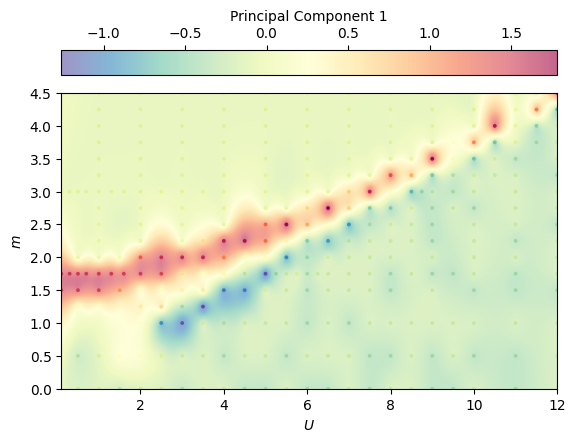

In [107]:
new_uvals = np.array(new_uvals)
new_mvals = np.array(new_mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(new_uvals), max(new_uvals), num_points),
                             np.linspace(min(new_mvals), max(new_mvals), num_points))

for i in range (0,PCA_num):
    


    rbf = Rbf(new_uvals, new_mvals, principal_components[:, i], function='linear')
    interp_vals = rbf(u_grid, m_grid)


    #normalized_values = (principal_components[:, i] - (-0.2)) / (0.4 - (-0.2))
    normalized_values = (principal_components[:, i])

    plt.imshow(interp_vals, extent=(min(new_uvals), max(new_uvals), min(new_mvals), max(new_mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
    plt.colorbar(label=f"Principal Component {i+1}",location='top')
    plt.xlabel(r'$U$')
    plt.scatter(new_uvals, new_mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
    plt.ylabel(r'$m$')
    plt.show()


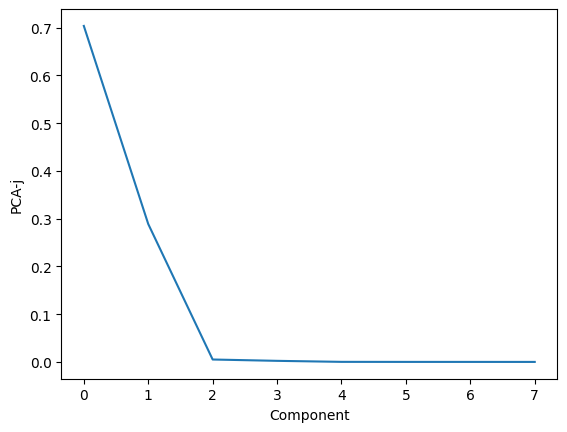

In [108]:
M = 39
model = PCA(n_components=8)
principal_components = model.fit_transform(x_train)
eigenvalues = model.explained_variance_

# store the results
λ = model.explained_variance_
PCAj = model.explained_variance_ratio_
principal_axes = model.components_

fig,ax = plt.subplots()

ax.plot(PCAj)
ax.set_ylabel('PCA-j')
ax.set_xlabel('Component');

In [109]:
# Unlike before, the relationship isn't entirely linear

In [110]:
# running PCA on only the spin spin correlations

In [111]:
only_cors_zeroed = only_cors - np.min(only_cors)
only_cors_zeroed = np.squeeze(only_cors_zeroed/np.max(only_cors_zeroed))

In [112]:
PCA_num = 1
pca = PCA(n_components=PCA_num)
principal_components = pca.fit_transform(only_cors_zeroed)
eigenvalues = pca.explained_variance_

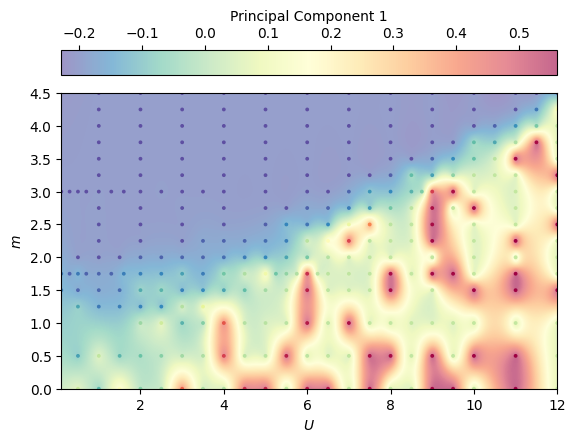

In [113]:
new_uvals = np.array(new_uvals)
new_mvals = np.array(new_mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(new_uvals), max(new_uvals), num_points),
                             np.linspace(min(new_mvals), max(new_mvals), num_points))

for i in range (0,PCA_num):
    


    rbf = Rbf(new_uvals, new_mvals, principal_components[:, i], function='linear')
    interp_vals = rbf(u_grid, m_grid)


    #normalized_values = (principal_components[:, i] - (-0.2)) / (0.4 - (-0.2))
    normalized_values = (principal_components[:, i])

    plt.imshow(interp_vals, extent=(min(new_uvals), max(new_uvals), min(new_mvals), max(new_mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
    plt.colorbar(label=f"Principal Component {i+1}",location='top')
    plt.xlabel(r'$U$')
    plt.scatter(new_uvals, new_mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
    plt.ylabel(r'$m$')
    plt.show()


In [114]:
# Here we train a normal autoencoder using cosine similarity

In [115]:
orbs_shape = len(orb_cors_n[0])

In [116]:
autoencoder = keras.Sequential(
[
    keras.layers.Dense(100, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(30, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(1, activation='linear', name="middle"),
    keras.layers.Dense(30, activation='tanh'),
    keras.layers.Dense(100, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(orbs_shape, activation='linear')
])
autoencoder.compile(loss='cosine_similarity', optimizer='Adam', metrics=['accuracy'])
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               1600      
                                                                 
 dense_14 (Dense)            (None, 30)                3030      
                                                                 
 middle (Dense)              (None, 1)                 31        
                                                                 
 dense_15 (Dense)            (None, 30)                60        
                                                                 
 dense_16 (Dense)            (None, 100)               3100      
                                                                 
 dense_17 (Dense)            (None, 15)                1515      
                                                                 
Total params: 9336 (36.47 KB)
Trainable params: 9336 (

In [117]:
batch_size = 20
epochs = 15
training_history = autoencoder.fit(x_train,x_train, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,x_test))

Epoch 1/15
13/13 [==============================] - 1s 10ms/step - loss: -0.6648 - accuracy: 0.4896 - val_loss: -0.7949 - val_accuracy: 0.4262
Epoch 2/15
13/13 [==============================] - 0s 2ms/step - loss: -0.8846 - accuracy: 0.5187 - val_loss: -0.8829 - val_accuracy: 0.5246
Epoch 3/15
13/13 [==============================] - 0s 2ms/step - loss: -0.9263 - accuracy: 0.8631 - val_loss: -0.8832 - val_accuracy: 0.9180
Epoch 4/15
13/13 [==============================] - 0s 2ms/step - loss: -0.9281 - accuracy: 0.9295 - val_loss: -0.8955 - val_accuracy: 0.9180
Epoch 5/15
13/13 [==============================] - 0s 2ms/step - loss: -0.9387 - accuracy: 0.6639 - val_loss: -0.9005 - val_accuracy: 0.4262
Epoch 6/15
13/13 [==============================] - 0s 2ms/step - loss: -0.9290 - accuracy: 0.5270 - val_loss: -0.9014 - val_accuracy: 0.4262
Epoch 7/15
13/13 [==============================] - 0s 2ms/step - loss: -0.9330 - accuracy: 0.5270 - val_loss: -0.9030 - val_accuracy: 0.4262
Epoch

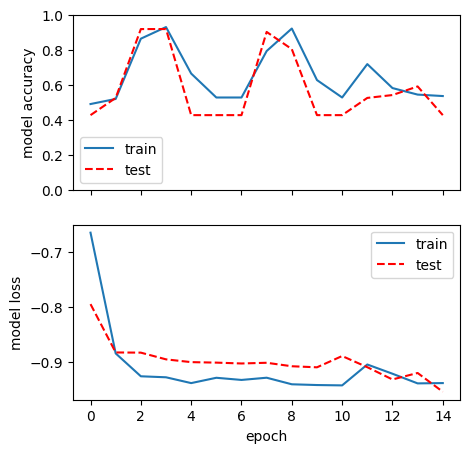

In [118]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

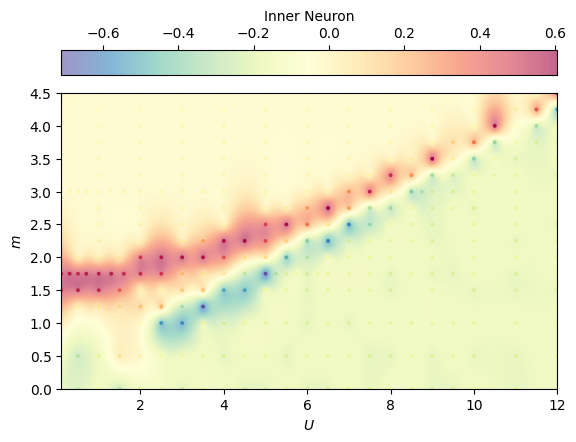

In [119]:
inner_neuron = keras.Model(
  inputs=autoencoder.input,
  outputs=autoencoder.get_layer("middle").output)

inner_output = np.array(inner_neuron(orb_cors_n))

# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(new_uvals), max(new_uvals), num_points),
                             np.linspace(min(new_mvals), max(new_mvals), num_points))

rbf = Rbf(new_uvals, new_mvals, inner_output, function='linear')
interp_vals = rbf(u_grid, m_grid)

#normalized_values = inner_output
normalized_values = (inner_output - (-0.2)) / (0.4 - (-0.2))

plt.imshow(interp_vals, extent=(min(new_uvals), max(new_uvals), min(new_mvals), max(new_mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(label="Inner Neuron",location='top')
plt.xlabel(r'$U$')
plt.scatter(new_uvals, new_mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')
plt.show()

In [120]:
 nice_colors = inner_output # for use in later plots, since it looks good

In [121]:
# Very cool separation.

In [122]:
# m and U

In [123]:
only_m = possible_values[:,0]
only_U = possible_values[:,1]

In [124]:
m_norm = only_m / np.max(only_m)
U_norm = only_U / np.max(only_U)

In [125]:
possible_values_norm = np.concatenate(np.expand_dims([m_norm, U_norm], axis = 2), axis = 1)

In [126]:
possible_values_norm[0]

array([0.5       , 0.83333333])

In [127]:
def undo_mU_norm(inputs):
    m = inputs[:,0]
    U = inputs[:,1]
    fixed_m = m*np.max(only_m)
    fixed_U = U*np.max(only_U)
    return np.concatenate(np.expand_dims([fixed_m, fixed_U], axis = 2), axis = 1)

In [128]:
undo_mU_norm(possible_values_norm)[0]

array([ 2.25, 10.  ])

In [129]:
#testing_orbs = orb_cors_n[:,:8]
testing_orbs = orb_cors_n

In [130]:
x_train, x_test, y_train, y_test = train_test_split(testing_orbs, possible_values_norm, test_size=0.2)

In [131]:
orbs_shape = len(x_train[0])
network = keras.Sequential(
[
    keras.layers.Dense(300, input_shape = (orbs_shape,), activation='tanh'),
    keras.layers.Dense(300, activation='tanh'),
    keras.layers.Dense(300, activation='tanh'),
    keras.layers.Dense(300, activation='tanh'),
    keras.layers.Dense(2, activation='sigmoid')
])
network.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
network.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 300)               4800      
                                                                 
 dense_19 (Dense)            (None, 300)               90300     
                                                                 
 dense_20 (Dense)            (None, 300)               90300     
                                                                 
 dense_21 (Dense)            (None, 300)               90300     
                                                                 
 dense_22 (Dense)            (None, 2)                 602       
                                                                 
Total params: 276302 (1.05 MB)
Trainable params: 276302 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [132]:
batch_size = 20
epochs = 300
training_hist = network.fit(x_train,y_train, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test))

Epoch 1/300
13/13 [==============================] - 1s 10ms/step - loss: 0.0719 - accuracy: 0.8880 - val_loss: 0.0626 - val_accuracy: 0.5410
Epoch 2/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0737 - accuracy: 0.8963 - val_loss: 0.0618 - val_accuracy: 0.9344
Epoch 3/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9004 - val_loss: 0.0563 - val_accuracy: 0.9344
Epoch 4/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.9087 - val_loss: 0.0601 - val_accuracy: 0.9344
Epoch 5/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0652 - accuracy: 0.9336 - val_loss: 0.0559 - val_accuracy: 0.9180
Epoch 6/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0620 - accuracy: 0.9336 - val_loss: 0.0607 - val_accuracy: 0.8197
Epoch 7/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.9295 - val_loss: 0.0583 - val_accuracy: 0.9344
Epoch 8/300


In [133]:
actual_mU = undo_mU_norm(possible_values_norm)
pred_mU = undo_mU_norm(network(testing_orbs))

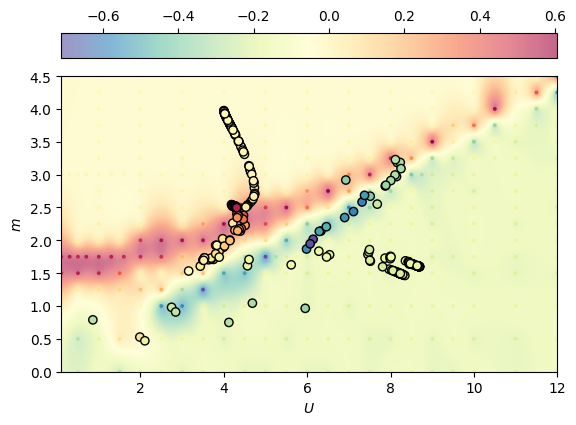

In [134]:
rbf = Rbf(new_uvals, new_mvals, nice_colors, function='linear')
interp_vals = rbf(u_grid, m_grid)

plt.imshow(interp_vals, extent=(min(new_uvals), max(new_uvals), min(new_mvals), max(new_mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(location='top')
plt.xlabel(r'$U$')
plt.scatter(new_uvals, new_mvals, c=nice_colors, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')

plt.scatter(pred_mU[:,1], pred_mU[:,0], c = nice_colors, cmap='Spectral_r', edgecolors= "black")
plt.show()

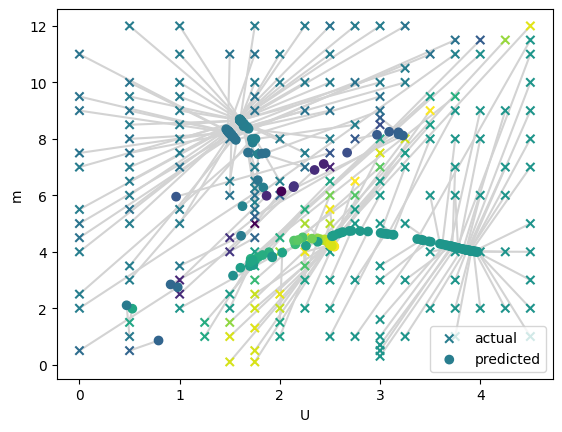

In [135]:
points = 200
for i in range (0, points):
    plt.plot([actual_mU[i,0], pred_mU[i,0]], [actual_mU[i,1], pred_mU[i,1]], color = "lightgray")


plt.scatter(actual_mU[:points,0], actual_mU[:points,1], label = "actual", zorder = 2, c = nice_colors[:points], marker = "x")
plt.scatter(pred_mU[:points,0], pred_mU[:points,1], label = "predicted", zorder = 3, c = nice_colors[:points])

plt.xlabel("U")
plt.ylabel("m")
plt.legend()

In [157]:
# Making another VAE with MSE

In [137]:
x_train, x_test, y_train, y_test = train_test_split(orb_cors_n, orb_cors_n, test_size=0.2)
orbs_shape = len(orb_cors[0])

In [138]:
# Input dimensions
input_dim = orbs_shape

# Latent space dimension
latent_dim = 1

# List of input layers 
layer_list = [(100,'tanh'), (30,'tanh')]


inputs = keras.Input(shape=(input_dim,))
layer = []
previous_layer = inputs
for i, (dim, activ) in enumerate(layer_list):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1}')(previous_layer)
    previous_layer = layer
z_mean = layers.Dense(latent_dim, name = 'z_mean')(layer)
z_log_sigma = layers.Dense(latent_dim, name = 'z_log_sigma')(layer)

In [139]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [140]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [141]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 Dense_1 (Dense)             (None, 100)                  1600      ['input_3[0][0]']             
                                                                                                  
 Dense_2 (Dense)             (None, 30)                   3030      ['Dense_1[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 1)                    31        ['Dense_2[0][0]']             
                                                                                            

In [142]:
# Making decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
previous_layer = latent_inputs

for i, (dim, activ) in enumerate(layer_list[::-1]):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1+len(layer_list)}')(previous_layer)
    previous_layer = layer

outputs = layers.Dense(input_dim, activation='tanh')(layer)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [143]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1)]               0         
                                                                 
 Dense_3 (Dense)             (None, 30)                60        
                                                                 
 Dense_4 (Dense)             (None, 100)               3100      
                                                                 
 dense_23 (Dense)            (None, 15)                1515      
                                                                 
Total params: 4675 (18.26 KB)
Trainable params: 4675 (18.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
# Make VAE
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='VAE')

In [145]:
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15)]              0         
                                                                 
 encoder (Functional)        [(None, 1),               4692      
                              (None, 1),                         
                              (None, 1)]                         
                                                                 
 decoder (Functional)        (None, 15)                4675      
                                                                 
Total params: 9367 (36.59 KB)
Trainable params: 9367 (36.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [146]:
# making loss function
#reconstruction_loss = keras.losses.mean_absolute_percentage_error(inputs, outputs)
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
#reconstruction_loss = keras.losses.mean_squared_logarithmic_error(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, metrics=['accuracy'])

In [147]:
epochs = 500

training_history = vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(x_test, x_test), verbose = 1)

Epoch 1/500
8/8 [==============================] - 1s 18ms/step - loss: 0.5341 - accuracy: 0.2822 - val_loss: 0.5644 - val_accuracy: 0.5246
Epoch 2/500
8/8 [==============================] - 0s 4ms/step - loss: 0.4105 - accuracy: 0.4398 - val_loss: 0.4317 - val_accuracy: 0.5902
Epoch 3/500
8/8 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.5394 - val_loss: 0.3451 - val_accuracy: 0.6393
Epoch 4/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2720 - accuracy: 0.5602 - val_loss: 0.3035 - val_accuracy: 0.6721
Epoch 5/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2404 - accuracy: 0.5560 - val_loss: 0.2939 - val_accuracy: 0.6557
Epoch 6/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2199 - accuracy: 0.6100 - val_loss: 0.2368 - val_accuracy: 0.7049
Epoch 7/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.6183 - val_loss: 0.2351 - val_accuracy: 0.7049
Epoch 8/500
8/8 [=========

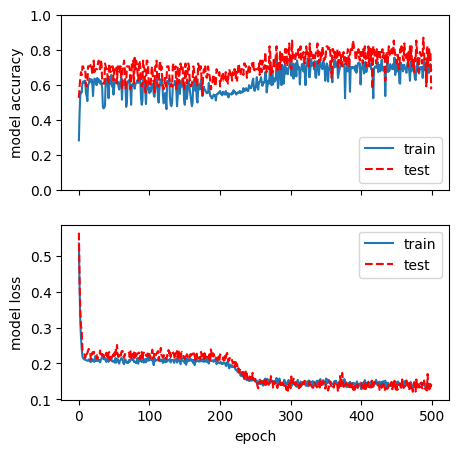

In [148]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

16/16 [==============================] - 0s 763us/step


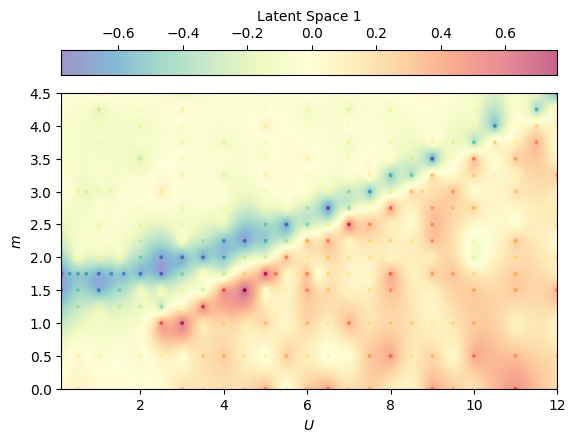

In [149]:
encoded = encoder.predict(orb_cors_n, batch_size=batch_size)[2]

for i in range (0, np.shape(encoded)[1]):



    which_latent = i

    latent_value = encoded[:,which_latent]
    uvals = np.array(new_uvals)
    mvals = np.array(new_mvals)


    # Set the number of points for interpolation
    num_points = 1000  

    # Create a grid for interpolation 
    u_grid, m_grid = np.meshgrid(np.linspace(min(new_uvals), max(new_uvals), num_points),
                             np.linspace(min(new_mvals), max(new_mvals), num_points))

    rbf = Rbf(uvals, mvals, latent_value, function='linear')
    interp_vals = rbf(u_grid, m_grid)

    normalized_values = latent_value
    #normalized_values = (latent_value - (-0.2)) / (0.4 - (-0.2))

    plt.imshow(interp_vals, extent=(min(new_uvals), max(new_uvals), min(new_mvals), max(new_mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
    plt.colorbar(label=f"Latent Space {which_latent+1}",location='top')
    plt.xlabel(r'$U$')
    plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
    plt.ylabel(r'$m$')
    
    plt.show()

In [150]:
def undo_norm(inputs):
    n_orbs = int(len(inputs[0])-7)
    inp_orbs = inputs[:,:n_orbs]*np.max(only_orbs)
    inp_cors = inputs[:,n_orbs:]*np.max(only_cors)

    return np.concatenate([inp_orbs,inp_cors], axis = 1)

In [151]:
def multidisplay(inputs, inputs_2 = np.array([]), mu = possible_values, num_cols = 4, extra_labels = []):
    n = len(inputs)
    num_rows = 2*int(np.ceil(n/num_cols))
    if len(inputs_2) == 0:
        second_input = False
    else:
        second_input = True

    if len(extra_labels) == 0:
        showing_generated = False
    else:
        showing_generated = True

    
    # sharex=True,sharey=True,
    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols,4*num_rows))
    fig.tight_layout(h_pad = 4)

    n_s = int((len(inputs[0])-7)/2) # this is just the number of s orbitals (and number of p orbitals), to plot them seperately
    
    for i in range(0, num_rows):
        for j in range (0,num_cols):
            if i% 2 == 0:
                index = int(j+i*num_cols/2)
                ax[i,j].plot(inputs[index][:n_s], label = "s")
                ax[i,j].plot(inputs[index][n_s:2*n_s], label = "p")


                if showing_generated == True:
                    ax[i,j].set_title(f"Sample Point = {extra_labels[index]}\nPredicted: m = {mu[index][0]:.4f}, U = {mu[index][1]:.4f}")

                else:
                    ax[i,j].set_title(f"#{index} Orbitals\nm = {mu[index][0]}, U = {mu[index][1]}")

                if second_input:
                
                    ax[i,j].plot(inputs_2[index][:n_s], label = "s (2)")
                    ax[i,j].plot(inputs_2[index][n_s:2*n_s], label = "p (2)")

                ax[i,j].legend()
                
            else:
                index = int(j+(i-1)*num_cols/2)
                ax[i,j].plot(inputs[index][2*n_s:], label = "SS_cors")

                if showing_generated == True:
                    ax[i,j].set_title(f"Sample Point= {extra_labels[index]}\nPredicted: m = {mu[index][0]:.4f}, U = {mu[index][1]:.4f}")
                else:   
                    ax[i,j].set_title(f"#{index} Spin Correlations\nm = {mu[index][0]}, U = {mu[index][1]}")
                ax[i,j].set_xticks(range(0,7))

                
                
                if second_input:
                
                    ax[i,j].plot(inputs_2[index][2*n_s:], label = "SS_cors (2)")

                ax[i,j].legend()
                ax[i,j].set_xlabel("d")
                ax[i,j].set_ylabel("S(d)")

        


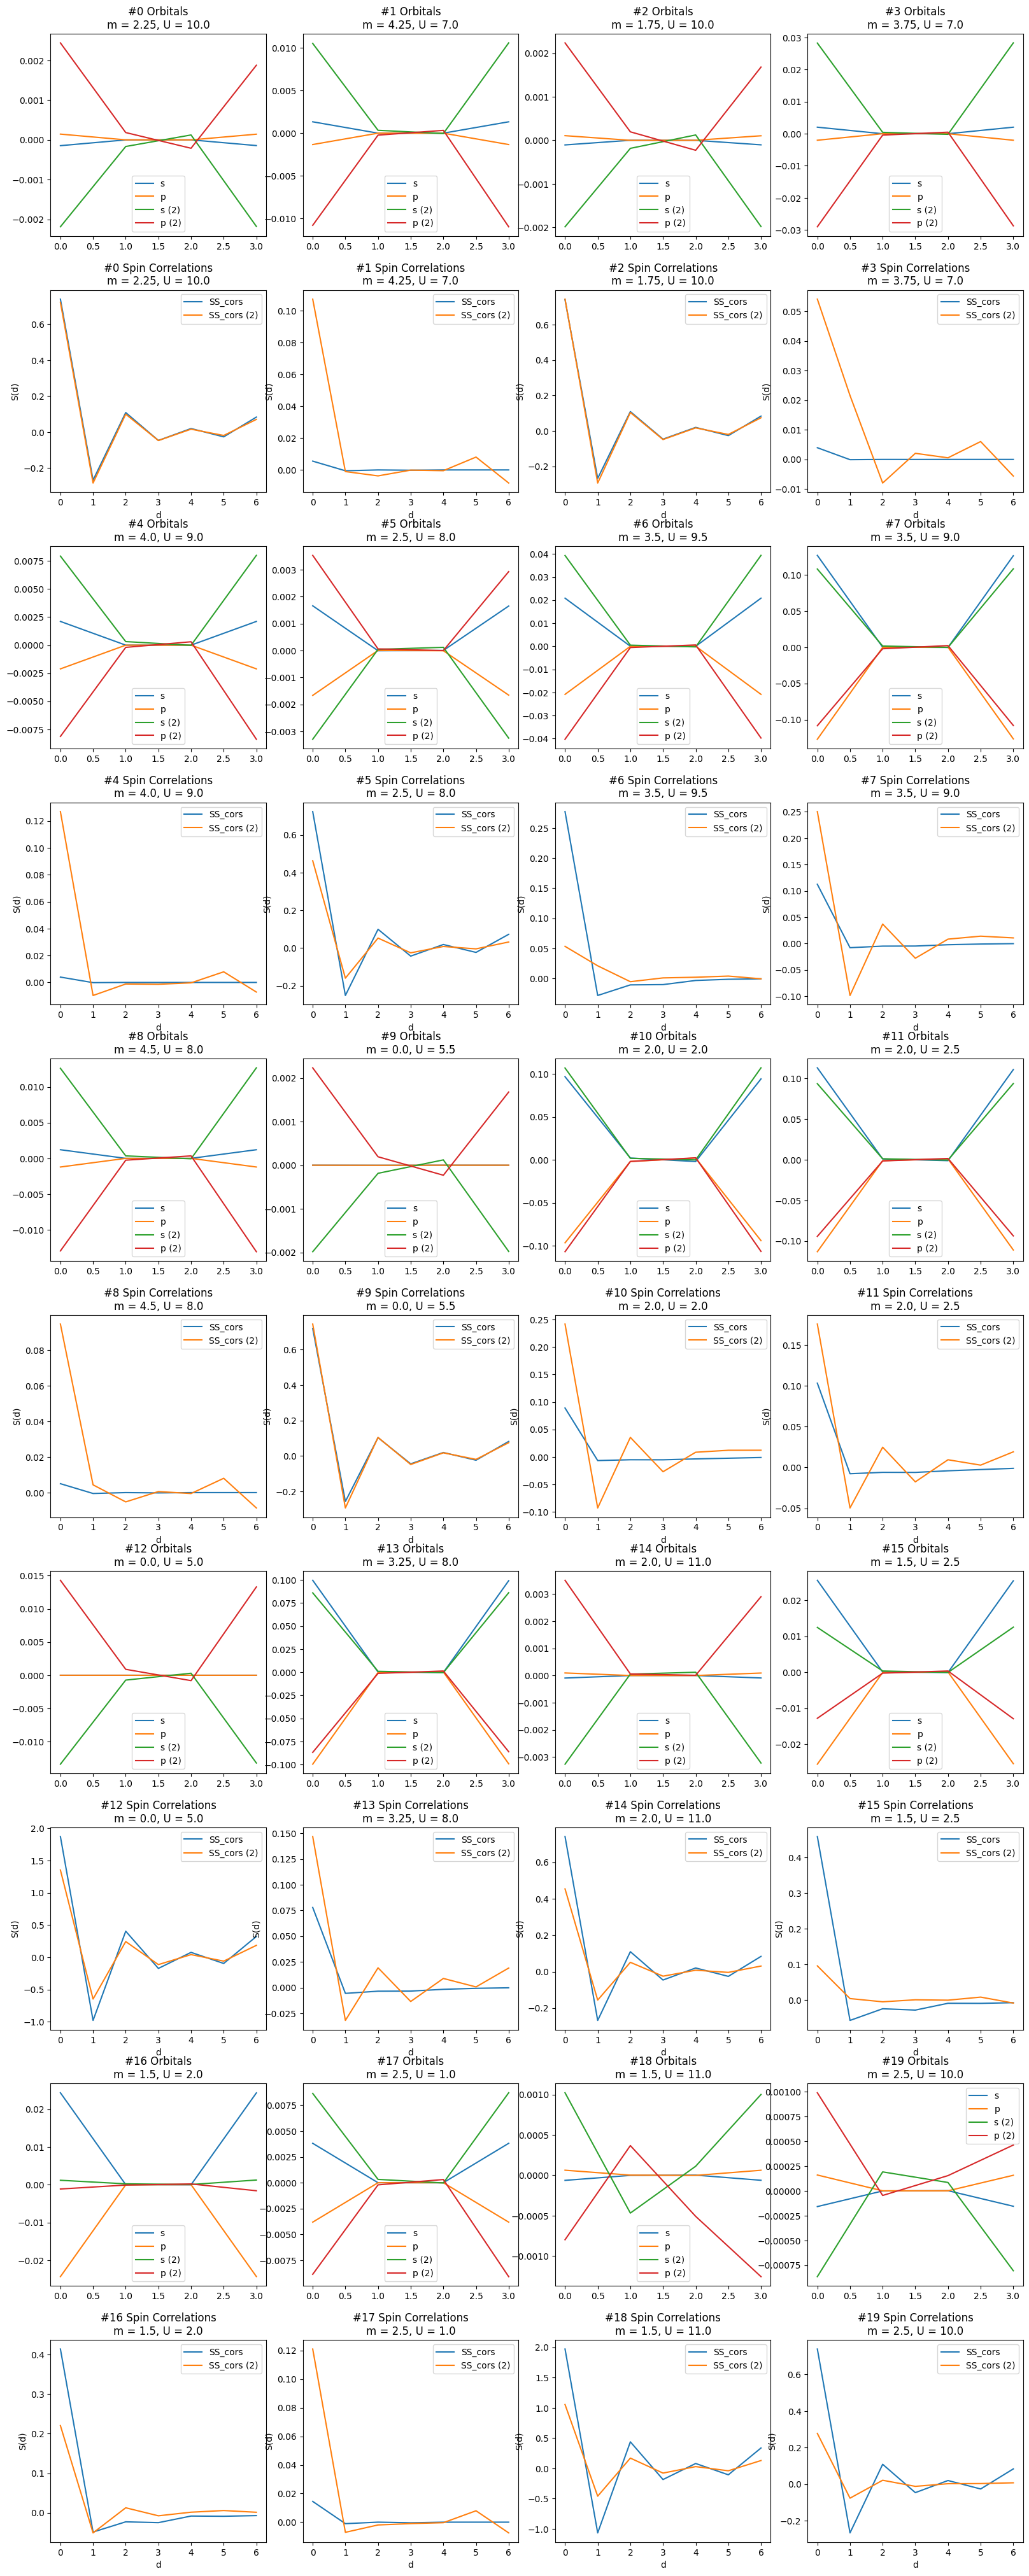

In [152]:
multidisplay(undo_norm(orb_cors_n[:20]), undo_norm(vae(orb_cors_n[:20])))

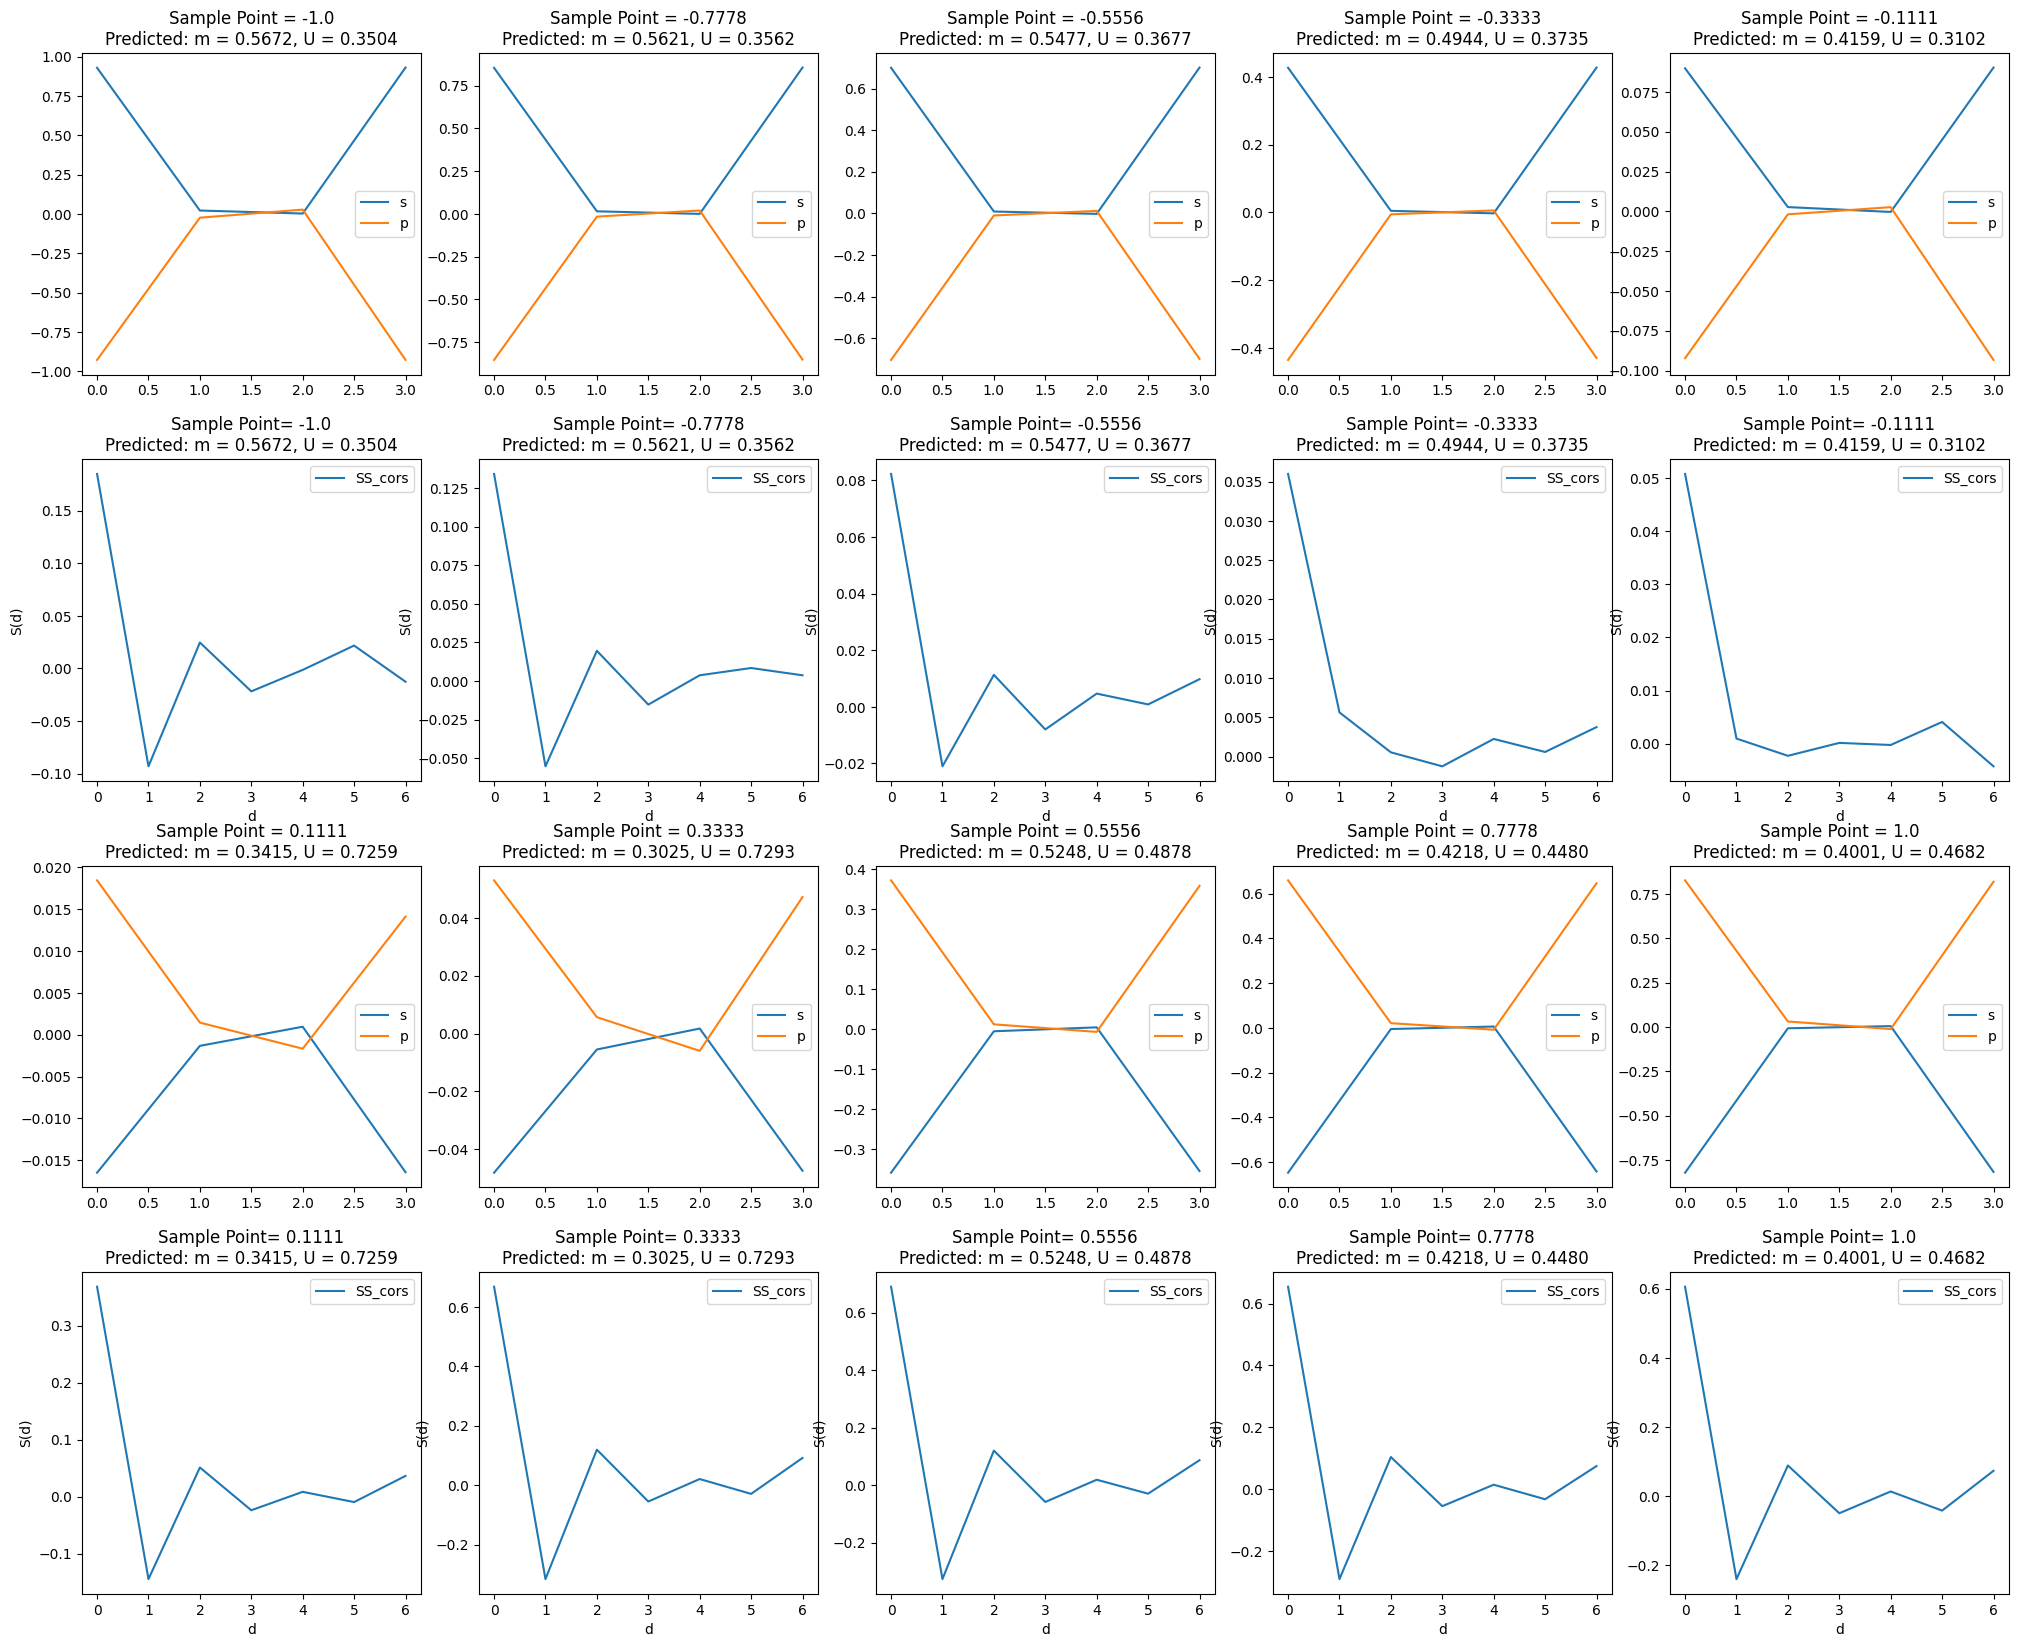

In [153]:
sample_points = np.linspace(-1,1,10) # sampling between -1 and 1 stdev

sample_points_rd = np.round(sample_points,4)

generated_orbs = decoder(sample_points)

generated_mU = network(generated_orbs)

multidisplay(generated_orbs, mu = generated_mU, num_cols = 5, extra_labels = sample_points_rd)